In [1]:
import sys
import os
sys.path.append("../")

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from rich import print as rich_print

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

from numba import njit

In [2]:
#filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/ttHbb/store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2500000/6BF93845-49D5-2547-B860-4F7601074715.root"
filename= "root://rdr.echo.stfc.ac.uk//store/mc/RunIISummer20UL16NanoAODAPVv9/ttHTobb_ttToSemiLep_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/60000/A578687F-E801-D747-9EDB-5E3CF99A9C5A.root"
#filename = "root://storage01.lcg.cscs.ch:1096//pnfs/lcg.cscs.ch/cms/trivcat//store/user/dvalsecc/ttHbb_p1j_EFT_signal_SMcenter/SMEFTsim_topU3l_SM_reweight10p0_v2/240418_053206/0000/test_eft_108.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100000).events()

genparts = events.GenPart

# Explore GenParticles again

In [3]:
genparts = events.GenPart
hard_process = genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess', 'isFirstCopy']) 
from_hard_process_lastcopy = genparts.hasFlags(['fromHardProcess','isPrompt', 'isLastCopy'])  & ~genparts.hasFlags(['isHardProcess'])

fullyhad = ak.sum((abs(genparts[hard_process].pdgId) >=11 ) &(abs(genparts[hard_process].pdgId) <19), axis=1)==0
semilep = ak.sum((abs(genparts[hard_process].pdgId) >=11 ) &(abs(genparts[hard_process].pdgId) <19), axis=1)==2
fullylep = ak.sum((abs(genparts[hard_process].pdgId) >=11 ) &(abs(genparts[hard_process].pdgId) <19), axis=1)==4

(array([   0.,    0.,    0.,    0.,    0., 4364.,    0.,    0.,    0.,
           0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <BarContainer object of 10 artists>)

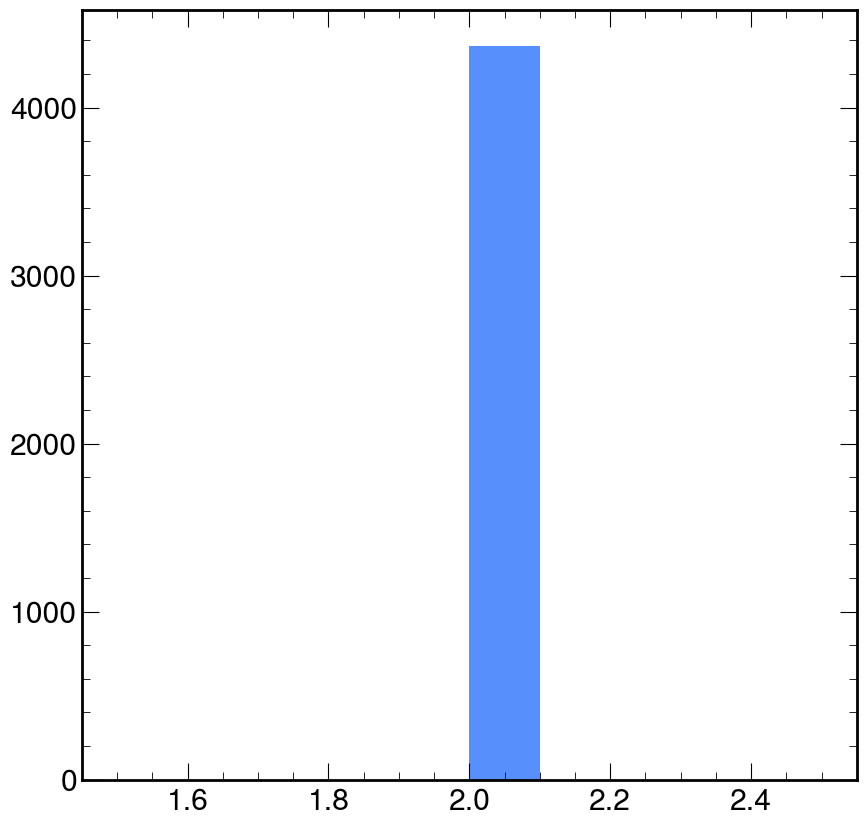

In [5]:
plt.hist(ak.sum(
            (abs(events.LHEPart.pdgId) >= 11) & (abs(events.LHEPart.pdgId) < 19), axis=1
        ))

Text(1, 0, 'N. of leptons in the hard process')

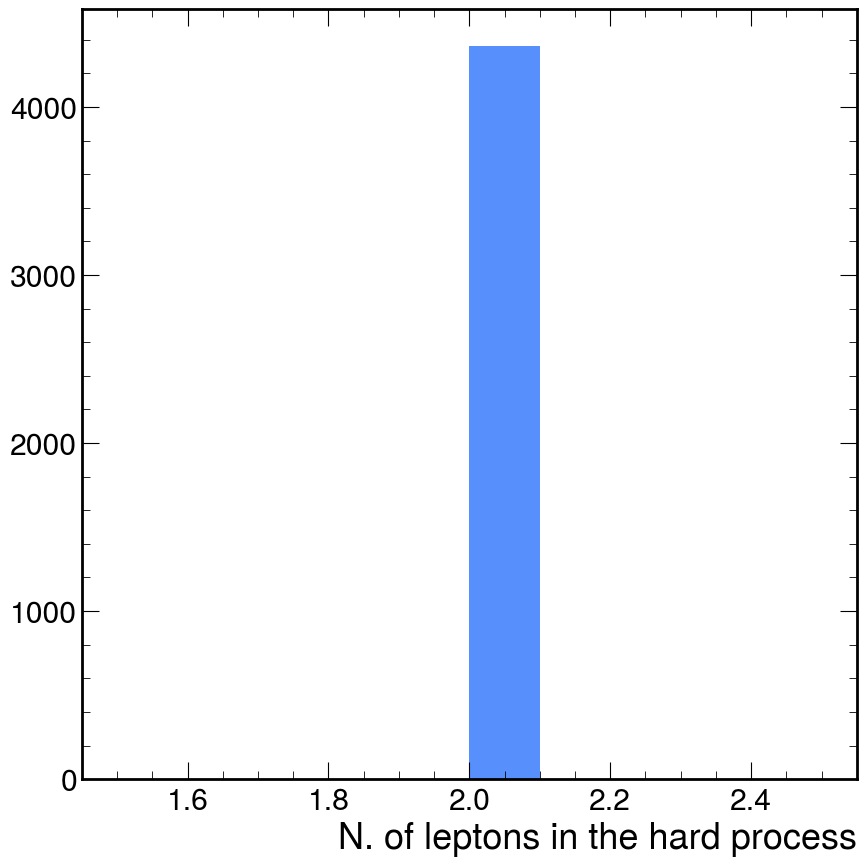

In [6]:
plt.hist(ak.sum((abs(genparts[hard_process].pdgId) >=11 ) &(abs(genparts[hard_process].pdgId) <19), axis=1))
plt.xlabel("N. of leptons in the hard process")

In [8]:
genparts[hard_process][ak.sum(
            (abs(events.LHEPart.pdgId) >= 11) & (abs(events.LHEPart.pdgId) < 19), axis=1
        )==0].pdgId[0:10].tolist()

[]

In [9]:
ak.sum(semilep) / len(semilep)

1.0

In [9]:
# Get the initial partons, first copy
initial = genparts[hard_process].genPartIdxMother == 0

is_higgs = genparts[hard_process][initial].pdgId == 25
is_top = genparts[hard_process][initial].pdgId == 6
is_antitop = genparts[hard_process][initial].pdgId == -6
local_index = ak.local_index(genparts, axis=1)

from_higgs = ak.fill_none(genparts[hard_process].parent.pdgId == 25, False)
from_top = ak.fill_none(genparts[hard_process].parent.pdgId == 6, False)
from_antitop = ak.fill_none(genparts[hard_process].parent.pdgId == -6, False)

from_W = ak.fill_none(genparts[hard_process].parent.pdgId == 24, False)
from_antiW = ak.fill_none(genparts[hard_process].parent.pdgId == -24, False)

### Print the gen tree

In [111]:
N_genpart_event = ak.num(genparts, axis=1)
genpart_index_offset = np.concatenate([[0],np.cumsum(N_genpart_event)])
genparts_flat = ak.flatten(genparts)

def reverse_index(idxG):
    event_idx = ak.local_index(genpart_index_offset)[(genpart_index_offset-idxG) > 0][0] - 1
    genpart_idx =  idxG - genpart_index_offset[event_idx]
    return event_idx, genpart_idx

def print_tree(idxG, offset=0):
    part = genparts_flat[idxG]
    idx = reverse_index(idxG)
    
    
    if part.hasFlags(['fromHardProcess','isHardProcess', 'isPrompt', 'isFirstCopy']) and part.status!=21:
        print('+ '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
        print("         --> initial copy, hard process ", end="")
    else:
        print('| '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
    print()
    
    
    child = part.childrenIdxG
    #has_children = len(child)>0
    for partIdx in child:
        print_tree(partIdx, offset+1)
        
def print_tree_event(iev, idx):
    idxG = genpart_index_offset[iev] + idx
    print_tree(idxG)

In [14]:
for i in range(3):
    print_tree_event(i, 0)
    print("\n"+ "="*100)

pdgId:2, status:21, GenPart (0, 0), mother -1, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:0.000, eta:25344.000, phi:0.000
+ pdgId:25, status:22, GenPart (0, 2), mother 0, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:58.500, eta:1.609, phi:0.971         --> initial copy, hard process 
| | pdgId:25, status:44, GenPart (0, 6), mother 2, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:63.250, eta:1.570, phi:0.988
| | | pdgId:25, status:44, GenPart (0, 7), mother 6, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:63.125, eta:1.582, phi:0.990
| | | | pdgId:25, status:44, GenPart (0, 8), mother 7, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:63.375, eta:1.582, phi:0.986
| | | | | pdgId:25, status:44, GenPart (0, 9), mother 8, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, is

In [57]:
genparts[0, 27].tolist()

{'eta': -2.3046875,
 'mass': 0.0,
 'phi': 1.12890625,
 'pt': 99.75,
 'genPartIdxMother': 11,
 'pdgId': -5,
 'status': 23,
 'statusFlags': 22913,
 'genPartIdxMotherG': 11,
 'distinctParentIdxG': 11,
 'childrenIdxG': [29, 31, 32],
 'distinctChildrenIdxG': [29, 32],
 'distinctChildrenDeepIdxG': [29, 32, 31]}

In [73]:
events.GenJet[0][["eta","phi","pt"]].tolist()

[{'eta': -2.3134765625, 'phi': 1.123779296875, 'pt': 96.11154174804688},
 {'eta': -1.824951171875, 'phi': 0.7115478515625, 'pt': 74.9963607788086},
 {'eta': 0.1966552734375, 'phi': -1.819091796875, 'pt': 71.32582092285156},
 {'eta': -2.2314453125, 'phi': -2.62841796875, 'pt': 53.73518371582031},
 {'eta': 2.4921875, 'phi': 0.99365234375, 'pt': 42.483192443847656},
 {'eta': -1.468017578125, 'phi': -1.765380859375, 'pt': 28.88640022277832},
 {'eta': -0.9979248046875, 'phi': -2.61328125, 'pt': 27.034351348876953},
 {'eta': -0.5635986328125, 'phi': -2.94677734375, 'pt': 21.965009689331055},
 {'eta': -0.33868408203125, 'phi': -2.08984375, 'pt': 13.6659574508667},
 {'eta': -0.00019797682762145996,
  'phi': -0.977294921875,
  'pt': 11.529422760009766}]

In [72]:
events.Jet[0][["eta","phi","pt", "genJetIdx"]].tolist()

[{'eta': -2.31103515625, 'phi': 1.10986328125, 'pt': 97.5, 'genJetIdx': 0},
 {'eta': -1.824951171875,
  'phi': 0.7117919921875,
  'pt': 86.625,
  'genJetIdx': 1},
 {'eta': 0.31134033203125,
  'phi': -1.8154296875,
  'pt': 54.3125,
  'genJetIdx': 2},
 {'eta': -2.25048828125, 'phi': -2.6328125, 'pt': 51.8125, 'genJetIdx': 3},
 {'eta': 2.49609375, 'phi': 0.995361328125, 'pt': 42.125, 'genJetIdx': 4},
 {'eta': -0.15740966796875,
  'phi': -1.912109375,
  'pt': 18.53125,
  'genJetIdx': 8},
 {'eta': -0.8463134765625,
  'phi': -2.60400390625,
  'pt': 16.671875,
  'genJetIdx': 6}]

### Get the initial copy before hadronization. 

In [6]:
#%%timeit
# Get the initial partons, first copy
initial = genparts.genPartIdxMother == 0
hard_process = (genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess', 'isFirstCopy'])) & (genparts.status !=21) # exclude incoming particles
genparts_hard = genparts[hard_process]

# I want to take hardProcess, final state, BEFORE FSR particles, which have higgs, top, antitop as parents
from_higgs = genparts_hard.parent.pdgId == 25
from_top = genparts_hard.parent.pdgId == 6
from_antitop = genparts_hard.parent.pdgId == -6

higgs = genparts_hard[genparts_hard.pdgId == 25]
top = genparts_hard[genparts_hard.pdgId == 6]
antitop = genparts_hard[genparts_hard.pdgId == -6]

genparts_initial = genparts[initial]

gluon = genparts_initial[(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                          (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)]

# Missing other initial particles

######
part_from_top = genparts_hard[from_top]
W_from_top = part_from_top[part_from_top.pdgId ==24]
b_from_top = part_from_top[part_from_top.pdgId ==5]
part_from_antitop = genparts_hard[from_antitop]
W_from_antitop = part_from_antitop[part_from_antitop.pdgId == -24]
b_from_antitop = part_from_antitop[part_from_antitop.pdgId == -5]

b_from_top_idx = ak.local_index(genparts, axis=1)[hard_process][from_top][part_from_top.pdgId ==5]
W_from_top_idx = ak.local_index(genparts, axis=1)[hard_process][from_top][part_from_top.pdgId == 24]

In [65]:
W_from_top_idx

<Array [[15], [14], [15], ... [10], [14], [19]] type='66000 * var * ?int64'>

Now get the W decays to get if the event is leptonic or not

In [68]:
W_from_antitop[0:5].tolist()

[[{'eta': -2.1640625,
   'mass': 78.0,
   'phi': -1.8828125,
   'pt': 32.25,
   'genPartIdxMother': 13,
   'pdgId': -24,
   'status': 22,
   'statusFlags': 4481,
   'genPartIdxMotherG': 13,
   'distinctParentIdxG': 13,
   'childrenIdxG': [20],
   'distinctChildrenIdxG': [],
   'distinctChildrenDeepIdxG': [24, 25]}],
 [{'eta': -0.3916015625,
   'mass': 80.75,
   'phi': -0.2626953125,
   'pt': 36.125,
   'genPartIdxMother': 12,
   'pdgId': -24,
   'status': 22,
   'statusFlags': 14721,
   'genPartIdxMotherG': 81,
   'distinctParentIdxG': 81,
   'childrenIdxG': [88, 89],
   'distinctChildrenIdxG': [88, 89, 101, 102],
   'distinctChildrenDeepIdxG': [88, 89]}],
 [{'eta': 2.4375,
   'mass': 81.0,
   'phi': 1.34765625,
   'pt': 30.1875,
   'genPartIdxMother': 13,
   'pdgId': -24,
   'status': 22,
   'statusFlags': 14721,
   'genPartIdxMotherG': 141,
   'distinctParentIdxG': 141,
   'childrenIdxG': [149, 150],
   'distinctChildrenIdxG': [149, 150, 151, 152],
   'distinctChildrenDeepIdxG': [149

### Print decay tree of the b quark from top

In [70]:
for iev in range(10):
    print_tree_event(iev, W_from_top_idx[iev][0])
    print("-"*100 + "\n")


pdgId:24, status:22, GenPart (0, 15), mother 12, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:69.000, eta:-1.898, phi:0.826         --> initial copy, hard process 
| pdgId:24, status:52, GenPart (0, 16), mother 15, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:69.000, eta:-1.902, phi:0.826
+ + pdgId:-13, status:1, GenPart (0, 22), mother 16, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:75.000, eta:-1.824, phi:0.711         --> initial copy, hard process 
+ + pdgId:14, status:1, GenPart (0, 23), mother 16, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:10.281, eta:0.110, phi:2.977         --> initial copy, hard process 
----------------------------------------------------------------------------------------------------

pdgId:24, status:22, GenPart (1, 14), mother 11, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCo

In [59]:
b_from_top.children[0:2].tolist()

[[[{'eta': -2.2265625,
    'mass': 0.0,
    'phi': -2.6484375,
    'pt': 44.5,
    'genPartIdxMother': 14,
    'pdgId': 5,
    'status': 71,
    'statusFlags': 8449,
    'genPartIdxMotherG': 14,
    'distinctParentIdxG': 12,
    'childrenIdxG': [],
    'distinctChildrenIdxG': [],
    'distinctChildrenDeepIdxG': []},
   {'eta': -2.2265625,
    'mass': 5.328125,
    'phi': -2.640625,
    'pt': 48.0,
    'genPartIdxMother': 14,
    'pdgId': -513,
    'status': 2,
    'statusFlags': 28675,
    'genPartIdxMotherG': 14,
    'distinctParentIdxG': 14,
    'childrenIdxG': [52],
    'distinctChildrenIdxG': [52],
    'distinctChildrenDeepIdxG': [52]}]],
 [[{'eta': -3.25,
    'mass': 0.0,
    'phi': 2.65625,
    'pt': 84.75,
    'genPartIdxMother': 13,
    'pdgId': 5,
    'status': 71,
    'statusFlags': 8449,
    'genPartIdxMotherG': 82,
    'distinctParentIdxG': 80,
    'childrenIdxG': [113],
    'distinctChildrenIdxG': [113],
    'distinctChildrenDeepIdxG': []}]]]

In [61]:
genparts[hard_process].parent.pdgId[0:10].tolist()

[[21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [-2, -2, -2, -2, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [2, 2, 2, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [21, 21, 21, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25],
 [-2, -2, -2, -2, 6, 6, -6, -6, 24, 24, -24, -24, 25, 25]]

In [62]:
genparts[hard_process][from_higgs].pdgId[0:10].tolist()

[[5, -5],
 [5, -5],
 [5, -5],
 [5, -5],
 [5, -5],
 [5, -5],
 [5, -5],
 [5, -5],
 [5, -5],
 [5, -5]]

In [176]:
genparts[from_gluon].status[0:10].tolist()

[[22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23],
 [22, 22, 22, 23]]

In [148]:
genparts[hard_process][from_top][:,0].children.pdgId[0:10].tolist()

[[5, -513],
 [5],
 [5],
 [5, -523, 21],
 [5],
 [5],
 [5, -511],
 [5, 21],
 [5, -521],
 [5, -523]]

In [142]:
genparts[hard_process][from_antitop].pdgId[0:10].tolist()

[[-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24],
 [-5, -24]]

In [63]:
for iev in range(2):
    print(f"\niev:{iev}")
    print_tree_event(iev, local_index[hard_process][iev, -1])
    
    print("\nJets eta: ", events.Jet[iev].eta.to_list())
    print("Jets phi: ", events.Jet[iev].phi.to_list())


iev:0
pdgId:-5, status:23, GenPart (0, 27), mother 11, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:99.750, eta:-2.305, phi:1.129         --> initial copy, hard process 
| pdgId:-513, status:2, GenPart (0, 29), mother 27, fromHardProcess:0, isHardProcess:0, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:31.125, eta:-1.488, phi:-1.773
| | pdgId:-511, status:2, GenPart (0, 49), mother 29, fromHardProcess:0, isHardProcess:0, isPrompt:0, isFirstCopy:1, isLastCopy:1         pt:30.688, eta:-1.488, phi:-1.773
| | | pdgId:413, status:2, GenPart (0, 57), mother 49, fromHardProcess:0, isHardProcess:0, isPrompt:0, isFirstCopy:1, isLastCopy:1         pt:16.500, eta:-1.438, phi:-1.723
| | | | pdgId:421, status:2, GenPart (0, 63), mother 57, fromHardProcess:0, isHardProcess:0, isPrompt:0, isFirstCopy:1, isLastCopy:1         pt:15.438, eta:-1.438, phi:-1.723
| | | | | pdgId:-13, status:1, GenPart (0, 66), mother 63, fromHardProcess:0, isHardProcess:0, is

In [77]:
genparts[hard_process][0:10].pdgId.tolist()

[[25, 6, -6, 5, 24, -5, -24, -13, 14, 3, -4, 5, -5],
 [25, 6, -6, 21, 5, 24, -5, -24, -3, 4, 3, -2, 5, -5],
 [25, 6, -6, 5, 24, -5, -24, -15, 16, 3, -4, 5, -5],
 [25, 6, -6, 5, 24, -5, -24, -3, 4, 11, -12, 5, -5],
 [25, 6, -6, 5, 24, -5, -24, -3, 4, 3, -4, 5, -5],
 [25, 6, -6, 5, 24, -5, -24, -15, 16, 15, -16, 5, -5],
 [21, 25, 6, -6, 5, 24, -5, -24, -1, 2, 13, -14, 5, -5],
 [25, 6, -6, 5, 24, -5, -24, -3, 4, 1, -2, 5, -5],
 [25, 6, -6, 5, 24, -5, -24, -3, 4, 1, -2, 5, -5],
 [25, 6, -6, 21, 5, 24, -5, -24, -1, 2, 1, -2, 5, -5]]

In [23]:
local_index[hard_process][from_W][0:10].tolist()

[[22, 23],
 [17, 18],
 [19, 20],
 [20, 21],
 [17, 18],
 [19, 20],
 [19, 20],
 [19, 20],
 [20, 21],
 [18, 19]]

# Handling offsets and lenghts in masked genparticles

In [154]:
lenghts = ak.num(genparts, axis=1)
offsets = np.concatenate([[0],np.cumsum(lenghts)])
genparts_flat = ak.flatten(genparts)
Ngenparts_tot = len(genparts_flat)

In [108]:
lenghts

<Array [69, 59, 78, 68, 60, ... 82, 86, 67, 86] type='1000 * int64'>

In [109]:
offsets

<Array [0, 69, 128, ... 79055, 79122, 79208] type='1001 * int64'>

In [147]:
mask = semilep

In [153]:
genparts[mask][10,2].tolist()

{'eta': 0.2900390625,
 'mass': 125.0,
 'phi': 2.96875,
 'pt': 106.5,
 'genPartIdxMother': 0,
 'pdgId': 25,
 'status': 22,
 'statusFlags': 4481,
 'genPartIdxMotherG': 2731,
 'distinctParentIdxG': 2731,
 'childrenIdxG': [2737],
 'distinctChildrenIdxG': [],
 'distinctChildrenDeepIdxG': [2757, 2758]}

In [155]:
new_offsets = np.concatenate([[0],np.cumsum(ak.num(genparts[mask]))])

In [156]:
new_offsets

<Array [0, 69, 137, ... 19985, 20060, 20146] type='264 * int64'>

In [140]:
indices = np.indices([len(genparts_flat)])

In [133]:
total_reduction_offset = np.zeros(Ngenparts_tot)
for i in range(len(events)):
    if not mask[i]:
        #print(lenghts[i])
        #print(offsets[i])
        #print(np.ones(Ngenparts_tot))
        red = np.zeros(Ngenparts_tot) 
        red[offsets[i]:] = lenghts[i]
        total_reduction_offset -=  red

In [143]:
new_indices = indices[0] + total_reduction_offset

In [144]:
new_indices

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 7.9146e+04, 7.9147e+04,
       7.9148e+04])

In [ ]:
for i in range(len(new_indices)):
    print(i, new_indices[i])

This works if you have the original unmasked offset and the applied mask, it cannot be applied in general. 
We need to get the index of the first particles in the list

# Testing index reversing

In [18]:
N_genpart_event_original = ak.num(genparts, axis=1)
genpart_index_offset_original = np.concatenate([[0],np.cumsum(N_genpart_event_original)])
genpart_index_offset_original

<Array [0, 69, 128, ... 5152473, 5152553] type='66001 * int64'>

In [19]:
mask = semilep
genparts_cut = genparts[mask]
N_genpart_event_cut  = ak.num(genparts_cut, axis=1)
genpart_index_offset_cut = np.concatenate([[0],np.cumsum(N_genpart_event_cut)])
genparts_flat_cut = ak.flatten(genparts_cut)

In [9]:
genparts[genparts.genPartIdxMother == -1].pdgId[0:50].tolist()

[[21, 21, 2],
 [-2, 2, -413, 421, 2, 2203, 1, -2],
 [21, 21, 3, 21, -2, 3, 21, -1, 2, 1, 2],
 [21, 21, 2, 21, 21, -2],
 [21, 2, 2],
 [2, 21, 21, 2, 21, 1],
 [21, 21, 2, 21, 21],
 [21, 21, 2, -1, 1, -3],
 [21, 21, -413, 2, 21, 21, 21, 421, 1, -3],
 [-2, 2, 1, 2101],
 [21, 21, 2, -1, 21],
 [2, 21, 4, -4, 4, 1, -2, -3],
 [2, 21, 1, -1],
 [2, 21, 1, -2],
 [2, 21, -4, 2, 2, 3, 4],
 [21, 21, 1, -3],
 [21, 2, 21, -2, 2, -3],
 [-2, 2, 21, 21, 2, 21, 21],
 [21, -2, -411, 423, -423, 3, -2, 1, -3, 421],
 [2, -2, 221],
 [2, 21, 4, 21, 2, -1, 21, -4],
 [21, 2, 21, 21, -3],
 [2, -2, 22, 3, 2203, 3, -3],
 [2, 21, 411, 21, -1, -4132],
 [21, 21, -431, 413, -423, -3, 423, 1, 21, 21, 21, 21, -4, 411, 2, -2, 3, -3],
 [-1, 1, 4, 2, -4],
 [21, 21, -4, -411, 423, 2, 21, 21, -2],
 [21, 21],
 [21, 21],
 [-1, 1, 21, 2, 21, 21, -3],
 [21, 1, 3, 21],
 [21, 21, 423, 2, 2203, -431],
 [21, 21],
 [21, 21, 1, -2, 413, -423, 2, 21, -2],
 [2, -2],
 [21, 2, 21, -3],
 [1, 21],
 [21, 21, 21, -3],
 [21, 3, 2, -2],
 [21, -1]

In [36]:
top[mask].genPartIdxMotherG[0:10].tolist()

[[0], [128], [206], [430], [745], [911], [980], [1142], [1412], [1491]]

In [37]:
ak.firsts(genparts_cut[:,0].children).genPartIdxMotherG[0:10].tolist()

[0, 128, 206, 430, 745, 911, 980, 1142, 1412, 1491]

Now, knowding the global index of the first genparticle of each event we can build a new event offsets to be able to revert the index

In [45]:
N_genpart_event = ak.num(genparts, axis=1)
firstgenpart_idxG = ak.to_numpy(ak.firsts(genparts_cut[:,0].children).genPartIdxMotherG, allow_missing=False)
genpart_index_offset_cut = np.cumsum(firstgenpart_idxG)
genparts_flat_cut = ak.flatten(genparts_cut)

def reverse_index_with_cut(idxG):
    event_idx = ak.local_index(genpart_index_offset_cut)[(genpart_index_offset_cut-idxG) > 0][0] - 1
    genpart_idx =  idxG - genpart_index_offset_cut[event_idx]
    return event_idx, genpart_idx

In [53]:
reverse_index_with_cut(74791143442)

(29036, 3)

It works! Now we can get all the childrends and mothers with global indices also when we have cuts

# Analysis of decay with numba

In [4]:
def get_reverse_index_func(genparts):
    '''Builds a function compiled in numba to compute the reverse index from the genPartIdxMotherG global index.
    It works also with masked genparticles because the offsets is computed from the first genparticle of each event'''
    # This line is needed to get the global index of the first particle
    # first particle --> first childre --> genPartIdxMotherG
    firstgenpart_idxG = ak.firsts(genparts[:,0].children).genPartIdxMotherG
    firstgenpart_idxG_numpy = ak.to_numpy(firstgenpart_idxG, allow_missing=False)
    local_ind = ak.to_numpy(ak.local_index(firstgenpart_idxG), allow_missing=False)
    genparts_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genparts, axis=1), allow_missing=True))])
    nevents = firstgenpart_idxG_numpy.shape[0]
    print(nevents)
    
    @njit
    def reverse_index(idxG):
        event_idex = 0
        genpart_idx = 0
        found = False
        for j in range(nevents-1):
            if (firstgenpart_idxG_numpy[j+1] - idxG)>0:
                genpart_idx = idxG - firstgenpart_idxG_numpy[j]
                return j , genpart_idx
                found=True
                break
        if not found:
            genpart_idx = idxG - firstgenpart_idxG_numpy[nevents-1]
            return nevents-1, genpart_idx

    @njit
    def reverse_index_flat(idxG):
        '''Returns the index in the genparticle collection from the global indec. 
        N.B: if the genparts array has not been cut it is an identity. 
        If there have been masks this function converts correctly the global index to the new index'''
        event_idex = 0
        genpart_idx = 0
        found = False
        for j in range(nevents-1):
            if (firstgenpart_idxG_numpy[j+1] - idxG)>0:
                genpart_idx = idxG - firstgenpart_idxG_numpy[j]
                return genparts_offsets[j] + genpart_idx

        if not found:
            genpart_idx = idxG - firstgenpart_idxG_numpy[nevents-1]
            return genparts_offsets[nevents-1] + genpart_idx
        
    @njit
    def reverse_index_array(idxGs):
        out = np.zeros(len(idxGs), dtype="int64")
        for i, idxG in enumerate(idxGs):
            event_idex = 0
            genpart_idx = 0
            found = False
            for j in range(nevents-1):
                if (firstgenpart_idxG_numpy[j+1] - idxG)>0:
                    genpart_idx = idxG - firstgenpart_idxG_numpy[j]
                    out[i] = genparts_offsets[j] + genpart_idx
                    found=True
                    break
            if not found:
                genpart_idx = idxG - firstgenpart_idxG_numpy[nevents-1]
                out[i] = genparts_offsets[nevents-1] + genpart_idx

        return out
    
    return reverse_index, reverse_index_flat, reverse_index_array


In [5]:
### testing
reverse_index, reverse_index_flat, reverse_index_array = get_reverse_index_func(genparts)
print(reverse_index(175))
print(reverse_index(5152552))
print(reverse_index_flat(175))
print(reverse_index_array(np.array([175, 283, 1192,5152552])))

100000
(2, 29)
(66878, 25)
175
[    175     283    1192 5152552]


In [6]:
def print_tree(idxG, offset=0):
    part = genparts_flat[idxG]
    idx = reverse_index(idxG)
    
    if part.hasFlags(['fromHardProcess','isHardProcess', 'isPrompt', 'isFirstCopy']) and part.status!=21:
        print('+ '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
        print("         --> initial copy, hard process ", end="")
    else:
        print('| '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
    print()
    
    
    child = part.childrenIdxG
    #has_children = len(child)>0
    for partIdx in child:
        print_tree(reverse_index_flat(partIdx), offset+1)
        
def print_tree_event(iev, idx):
    idxG = genpart_index_offset[iev] + idx
    print_tree(idxG)

In [12]:
%%timeit
reverse_index(450)

197 ns ± 34.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [13]:
%%timeit
reverse_index_array(np.ones(10000)*10000)

1.78 ms ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# Get the initial partons, first copy
initial = genparts.genPartIdxMother == 0
hard_process = (genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess', 'isFirstCopy'])) & (genparts.status !=21) # exclude incoming particles
genparts_hard = genparts[hard_process]

# I want to take hardProcess, final state, BEFORE FSR particles, which have higgs, top, antitop as parents
from_higgs = genparts_hard.parent.pdgId == 25
from_top = genparts_hard.parent.pdgId == 6
from_antitop = genparts_hard.parent.pdgId == -6

higgs = genparts_hard[genparts_hard.pdgId == 25]
top = genparts_hard[genparts_hard.pdgId == 6]
antitop = genparts_hard[genparts_hard.pdgId == -6]

genparts_initial = genparts[initial]

isr = genparts_initial[(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                          (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)]
has_isr = ak.num(isr)!=0
isr_idx = ak.flatten(ak.fill_none(ak.pad_none(local_index_all[initial][(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                          (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)], 1), 0))

######
local_index_all = ak.local_index(genparts, axis=1)
part_from_top = genparts_hard[from_top]
W_from_top = ak.flatten(part_from_top[part_from_top.pdgId ==24])
b_from_top = ak.flatten(part_from_top[part_from_top.pdgId ==5])
part_from_antitop = genparts_hard[from_antitop]
W_from_antitop = ak.flatten(part_from_antitop[part_from_antitop.pdgId == -24])
b_from_antitop = ak.flatten(part_from_antitop[part_from_antitop.pdgId == -5])

b_from_top_idx = ak.flatten(local_index_all[hard_process][from_top][part_from_top.pdgId ==5])
W_from_top_idx = ak.flatten(local_index_all[hard_process][from_top][part_from_top.pdgId == 24])
b_from_antitop_idx = ak.flatten(local_index_all[hard_process][from_antitop][part_from_antitop.pdgId == -5])
W_from_antitop_idx = ak.flatten(local_index_all[hard_process][from_antitop][part_from_antitop.pdgId == -24])

# This works because they are the firstCopy of the hard_process particles with higgs as parent. We are skipping all the decay chain of the higgs
b_from_higgs_idx = local_index_all[hard_process][from_higgs]

NameError: name 'local_index_all' is not defined

In [243]:
# We can compute the global index using the function or using the offsets if we have the localindex
W_from_top_idxG = reverse_index_array(ak.to_numpy(ak.firsts(W_from_top.children).genPartIdxMotherG, allow_missing=False))
W_from_top_idxG

array([     15,      83,     143, ..., 5152343, 5152415, 5152492])

In [30]:
%%timeit
reverse_index_array(ak.to_numpy(ak.firsts(W_from_top.children).genPartIdxMotherG, allow_missing=False))

734 ms ± 29.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Preparing lists of indices we need in numba

In [36]:
children_idxG = ak.without_parameters(genparts.childrenIdxG, behavior={})
genparts_flat = ak.flatten(genparts)
genparts_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genparts, axis=1), allow_missing=True))])

We can now convert the list of children global indices in indices in the flatten genparticle collection. 
It is enough to genparts offsets

In [273]:
b_from_top_idxG = b_from_top_idx + genparts_offsets[:-1]
W_from_top_idxG = W_from_top_idx + genparts_offsets[:-1]
b_from_antitop_idxG = b_from_antitop_idx + genparts_offsets[:-1]
W_from_antitop_idxG = W_from_antitop_idx + genparts_offsets[:-1]
isr_idxG = isr_idx + genparts_offsets[:-1]

In [36]:
@njit
def convert_children_idx(chIdxG, builder):
    for iev, chidx_ev in enumerate(chIdxG):
        builder.begin_list()
        for c_part in chidx_ev:
            builder.begin_list()
            for i in reverse_index_array(c_part):
                builder.append(i)
            builder.end_list()
        builder.end_list()
    return builder
            

In [38]:
children_idxG_new = convert_children_idx(children_idxG[0:1000], ak.ArrayBuilder())

In [46]:
%%timeit
children_idxG_new = convert_children_idx(children_idxG[0:10000], ak.ArrayBuilder())

55.9 s ± 1.71 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


But this is too slow to do it for all the particles --> we just want to do it for the particles we need

In [23]:
iev = 2

In [32]:
print_tree_event(iev, W_from_top_idx[iev][0])

pdgId:24, status:22, GenPart (2, 15), mother 12, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:130.000, eta:2.070, phi:3.016         --> initial copy, hard process 
| pdgId:24, status:52, GenPart (2, 16), mother 15, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:127.500, eta:2.070, phi:3.008
+ + pdgId:-15, status:2, GenPart (2, 19), mother 16, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:14.500, eta:0.783, phi:-2.078         --> initial copy, hard process 
| | | pdgId:-16, status:1, GenPart (2, 51), mother 19, fromHardProcess:0, isHardProcess:0, isPrompt:0, isFirstCopy:1, isLastCopy:1         pt:13.688, eta:0.762, phi:-2.086
| | | pdgId:-13, status:1, GenPart (2, 52), mother 19, fromHardProcess:0, isHardProcess:0, isPrompt:0, isFirstCopy:1, isLastCopy:1         pt:0.588, eta:0.957, phi:-1.699
| | | pdgId:14, status:1, GenPart (2, 53), mother 19, fromHardProcess:0, 

From each genparticle we can have the list of children with global index. With the `reverse_index` function we get the index of the genparticle in the collection directly and we can then traverse the info

## Follow decay of the W

In [17]:
@njit
def analyze_W(W_idx, children_idx,genparts ):
    is_leptonic = np.zeros(len(genparts), dtype="bool")
    idx_children = np.zeros((len(genparts),2), dtype="int")
    # First go to children until don't find anymore the same copy
    for iev, ( W_id, gp, ch_idx) in enumerate(zip(W_idx,genparts, children_idx)):
        #print("-----\nevent: ", iev)
        current_part = W_id # start from the W
        while True:
            if len(ch_idx[current_part]) == 1:
                current_part  = reverse_index(ch_idx[current_part][0])[1]
                continue
            else:
                # We have now at least 2 children, checking if they are leptonic
                for ich,  ch in enumerate(ch_idx[current_part]):
                    cidx  = reverse_index(ch)[1]
                    if 11<= abs(gp[cidx].pdgId) <= 16:
                        #print("Found leptonic")
                        is_leptonic[iev] = True
                    idx_children[iev, ich] = cidx
                break
    return is_leptonic, idx_children

In [10]:
@njit
def analyze_W_flat(W_idx, children_idx,genparts ):
    is_leptonic = np.zeros(len(W_idx), dtype="bool")
    idx_children = np.zeros((len(W_idx),2), dtype="int")
    # We don't have a events, structure, using only flat collections
    
    # First go to children until don't find anymore the same copy
    for iev, W_id in enumerate(W_idx):
        #print("-----\nevent: ", iev)
        current_part = W_id # start from the W
        while True:
            #print(iev, current_part, genparts[current_part].pdgId)
            if genparts[current_part].statusFlags & 1<<13:  # is lastCopy
                break
            else:
                current_part = reverse_index_array(children_idx[current_part])[0]
                #print(current)
                # ASSUMING THAT THE FIRST CHILDREN IS THE COPY
#                 if abs(genparts[current_part].pdgId) != 24:
#                     print("BIG ERROR")
        
            
        # We have now at least 2 children, checking if they are leptonic
        for ich,  cidx in enumerate(reverse_index_array(children_idx[current_part])):
            if 11<= abs(genparts[cidx].pdgId) <= 16:
                #print("Found leptonic")
                is_leptonic[iev] = True
            idx_children[iev, ich] = cidx
        
    return is_leptonic, idx_children

In [44]:
%%timeit
out = analyze_W(ak.to_numpy(W_from_top_idx, allow_missing=False)[0:100], 
                 children_idxG[0:100], 
                ak.without_parameters(genparts[0:100],behavior={}))

4.01 ms ± 42.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit -r 20
out2 = analyze_W_flat(ak.to_numpy(W_from_top_idxG, allow_missing=False)[0:100], 
                 ak.flatten(children_idxG[0:100], axis=1), 
                 ak.without_parameters(ak.flatten(genparts[0:100], axis=1),behavior={}))

3.75 ms ± 610 µs per loop (mean ± std. dev. of 20 runs, 100 loops each)


Flat processing is 10% faster

In [ ]:
out2 = analyze_W_flat(ak.to_numpy(W_from_top_idxG, allow_missing=False)[0:100], 
                 ak.flatten(children_idxG[0:100], axis=1), 
                 ak.without_parameters(ak.flatten(genparts[0:100], axis=1),behavior={}))

In [77]:
%%timeit -n 10
out = analyze_W(ak.to_numpy(W_from_top_idx, allow_missing=False)[0:10000], 
          ak.without_parameters(ak.values_astype(children_idxG, "int")[0:10000], behavior={}), 
          ak.without_parameters(genparts[0:10000],behavior={}))

123 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%timeit -n 10
out = analyze_W_flat(ak.to_numpy(W_from_top_idxG, allow_missing=False)[0:10000], 
                 ak.flatten(children_idxG[0:10000], axis=1), 
                 ak.without_parameters(ak.flatten(genparts[0:10000], axis=1),behavior={}))

47.3 ms ± 7.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
for iev in range(5):
    print_tree_event(iev,W_from_top_idx[iev])
    print("-"*50)

pdgId:24, status:22, GenPart (0, 15), mother 12, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:69.000, eta:-1.898, phi:0.826         --> initial copy, hard process 
| pdgId:24, status:52, GenPart (0, 16), mother 15, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:69.000, eta:-1.902, phi:0.826
+ + pdgId:-13, status:1, GenPart (0, 22), mother 16, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:75.000, eta:-1.824, phi:0.711         --> initial copy, hard process 
+ + pdgId:14, status:1, GenPart (0, 23), mother 16, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:10.281, eta:0.110, phi:2.977         --> initial copy, hard process 
--------------------------------------------------
pdgId:24, status:22, GenPart (1, 14), mother 11, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:55.375, eta:-3.164, p

## Follow decay chain

In [127]:
for iev in range(13,14):
    print_tree_event(iev,b_from_antitop_idx[iev])
    print("-"*50 )
    print()

pdgId:-5, status:23, GenPart (13, 18), mother 14, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:9.312, eta:2.172, phi:-1.312         --> initial copy, hard process 
--------------------------------------------------



In [19]:
@njit
def analyze_parton_decays(parts_idx, children_idx, genparts):
    '''Expects local parts_idx index'''
    out = np.zeros(parts_idx.shape, dtype="int64")
    tot_gp = 0
    
    for iev, (gp, ch_idx) in enumerate(zip(genparts, children_idx)):
        for ipart in range(parts_idx.shape[1]):
            p_id = parts_idx[iev][ipart]            
            # Take all the children and consider the one with the highest pt. 
            max_pt = -1
            max_pt_idx = -1
            
            for i_ch in ch_idx[p_id]:
                r_ich = reverse_index(i_ch)[1]
                child = gp[r_ich]
                if child.pt > max_pt:
                    max_pt_idx = r_ich
                    max_pt = child.pt
                    
            if max_pt == -1:
                max_pt_idx = reverse_index(p_id)[1]
                
            out[iev, ipart] = tot_gp + max_pt_idx

        tot_gp += len(gp)
        
    return out

In [11]:
@njit
def analyze_parton_decays_flat_nomesons(parts_idx, children_idx, genparts, max_deltaR):
    '''Expects parts_idx in global index and chioldren_idx not.'''
    
    out = np.zeros(parts_idx.shape, dtype="int64")
    
    for iev in range(parts_idx.shape[0]):
        
    #for iev, (gp, ch_idx) in enumerate(zip(genparts, children_idx)):
        for ipart in range(parts_idx.shape[1]):
            p_id = parts_idx[iev][ipart]
            eta_original = genparts[p_id].eta
            phi_original = genparts[p_id].phi
            
            if abs(genparts[p_id].pdgId) > 8:
                continue
            # Take all the children and consider the one with the highest pt. 
            max_pt = -1
            max_pt_idx = -1
            childr_idxs = reverse_index_array(children_idx[p_id])
            
            for r_ich in childr_idxs:
                genp = genparts[r_ich]
                # Do no consider mesons
                if abs(genp.pdgId) > 21:
                    continue
                
                if np.sqrt((eta_original-genp.eta)**2 +(phi_original-genp.phi)**2 ) > max_deltaR:
                    continue
                    
                child_pt = genp.pt
                
                #print(child_pt)
                if child_pt > max_pt:
                    max_pt_idx = r_ich
                    max_pt = child_pt
            if max_pt == -1:
                max_pt_idx = p_id
            
            out[iev, ipart] = max_pt_idx
        
    return out

In [85]:
@njit
def analyze_parton_decays_flat(parts_idx, children_idx, genparts_pt):
    '''Expects parts_idx in global index and chioldren_idx not.'''
    
    out = np.zeros(parts_idx.shape, dtype="int64")
    
    for iev in range(parts_idx.shape[0]):
        
    #for iev, (gp, ch_idx) in enumerate(zip(genparts, children_idx)):
        for ipart in range(parts_idx.shape[1]):
            p_id = parts_idx[iev][ipart]
            # Take all the children and consider the one with the highest pt. 
            max_pt = -1
            max_pt_idx = -1
            childr_idxs = reverse_index_array(children_idx[p_id])
            for r_ich in childr_idxs:
                child_pt = genparts_pt[r_ich]
                
                #print(child_pt)
                if child_pt > max_pt:
                    max_pt_idx = r_ich
                    max_pt = child_pt
            if max_pt == -1:
                max_pt_idx = p_id
            
            out[iev, ipart] = max_pt_idx
        
    return out

In [76]:
@njit
def analyze_parton_decays_flat_inv(parts_idx, children_idx, genparts_pt):
    '''Expects parts_idx in global index and chioldren_idx not.'''
    
    out = np.zeros(parts_idx.shape, dtype="int64")
    for ipart in range(parts_idx.shape[1]):
    
        
    #for iev, (gp, ch_idx) in enumerate(zip(genparts, children_idx)):
        for iev in range(parts_idx.shape[0]):
            p_id = parts_idx[iev][ipart]
            # Take all the children and consider the one with the highest pt. 
            max_pt = -1
            max_pt_idx = -1
            childr_idxs = reverse_index_array(children_idx[p_id])
            for r_ich in childr_idxs:
                child_pt = genparts_pt[r_ich]
                #print(child_pt)
                if child_pt > max_pt:
                    max_pt_idx = r_ich
                    max_pt = child_pt
            if max_pt == -1:
                max_pt_idx = p_id
            
            out[iev, ipart] = max_pt_idx
        
    return out

In [78]:
part_input  = np.stack([ak.to_numpy(b_from_top_idx, allow_missing=False),
                        ak.to_numpy(b_from_antitop_idx, allow_missing=False)], axis=1)

part_input_G  = np.stack([ak.to_numpy(b_from_top_idxG, allow_missing=False),
                        ak.to_numpy(b_from_antitop_idxG, allow_missing=False)], axis=1)
part_input.shape

(100000, 2)

In [67]:
out = analyze_parton_decays(part_input[0:100], 
                          ak.without_parameters(ak.values_astype(children_idxG, "int")[0:100], behavior={}), 
                         ak.without_parameters(genparts[0:100],behavior={}))

In [68]:
out2 = analyze_parton_decays_flat(part_input_G[0:100], 
                          ak.flatten(children_idxG[0:100], axis=1), 
                         ak.without_parameters(ak.flatten(genparts.pt, axis=1),behavior={}))

In [114]:
out2 = analyze_parton_decays_flat_nomesons(part_input_G[0:100], 
                          ak.flatten(children_idxG[0:100], axis=1), 
                         ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}), 1)

In [79]:
%%timeit
out = analyze_parton_decays(part_input[0:10000], 
                          ak.without_parameters(ak.values_astype(children_idxG, "int")[0:10000], behavior={}), 
                         ak.without_parameters(genparts[0:10000],behavior={}))

160 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [136]:
%%timeit
out = analyze_parton_decays_flat_nomesons(part_input_G[0:10000], 
                          ak.flatten(children_idxG[0:10000], axis=1), 
                         ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}), 1.)

171 ms ± 27.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [140]:
%%timeit
out = analyze_parton_decays_flat(part_input_G[0:10000], 
                          ak.flatten(children_idxG[0:10000], axis=1), 
                         ak.without_parameters(ak.flatten(genparts.pt, axis=1),behavior={}))

287 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [139]:
%%timeit
out = analyze_parton_decays_flat_inv(part_input_G[0:10000], 
                          ak.flatten(children_idxG[0:10000], axis=1), 
                         ak.without_parameters(ak.flatten(genparts.pt, axis=1),behavior={}))

323 ms ± 41.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
out2

array([[     38,      19],
       [    112,      95],
       [    158,     171],
       ...,
       [5152360, 5152377],
       [5152445, 5152434],
       [5152526, 5152517]])

## Follow decay of the Higgs

In [206]:
for iev in range(5):
    print_tree_event(iev,b_from_higgs_idx[iev][0])
    print_tree_event(iev,b_from_higgs_idx[iev][1])
    print("-"*50)

pdgId:5, status:23, GenPart (0, 26), mother 11, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:33.250, eta:-1.488, phi:-1.777         --> initial copy, hard process 
| pdgId:5, status:71, GenPart (0, 28), mother 26, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:32.375, eta:-1.488, phi:-1.777
pdgId:-5, status:23, GenPart (0, 27), mother 11, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:99.750, eta:-2.305, phi:1.129         --> initial copy, hard process 
| pdgId:-513, status:2, GenPart (0, 29), mother 27, fromHardProcess:0, isHardProcess:0, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:31.125, eta:-1.488, phi:-1.773
| | pdgId:-511, status:2, GenPart (0, 49), mother 29, fromHardProcess:0, isHardProcess:0, isPrompt:0, isFirstCopy:1, isLastCopy:1         pt:30.688, eta:-1.488, phi:-1.773
| | | pdgId:413, status:2, GenPart (0, 57), mother 49, fromHardProcess:0, isHa

In [184]:
# global index using the offset
b_from_higgs_idx_G = ak.to_numpy(b_from_higgs_idx + genparts_offsets[:-1], allow_missing=False)

In [199]:
out_H = analyze_parton_decays_flat(b_from_higgs_idx_G, 
                          ak.flatten(children_idxG, axis=1), 
                         ak.without_parameters(ak.flatten(genparts.pt, axis=1),behavior={}))

In [205]:
out_H

array([[     28,      31],
       [    110,      91],
       [    162,     163],
       ...,
       [5152362, 5152364],
       [5152426, 5152442],
       [5152508, 5152523]])

(array([1.0000e+00, 1.0000e+00, 1.0000e+00, 4.0000e+00, 5.0000e+00,
        2.0000e+01, 4.7000e+01, 2.4100e+02, 6.0615e+04, 5.0650e+03]),
 array([ 92.92134094,  96.45922852,  99.99710846, 103.53499603,
        107.07287598, 110.61076355, 114.14865112, 117.68653107,
        121.22441864, 124.76229858, 128.30018616]),
 <BarContainer object of 10 artists>)

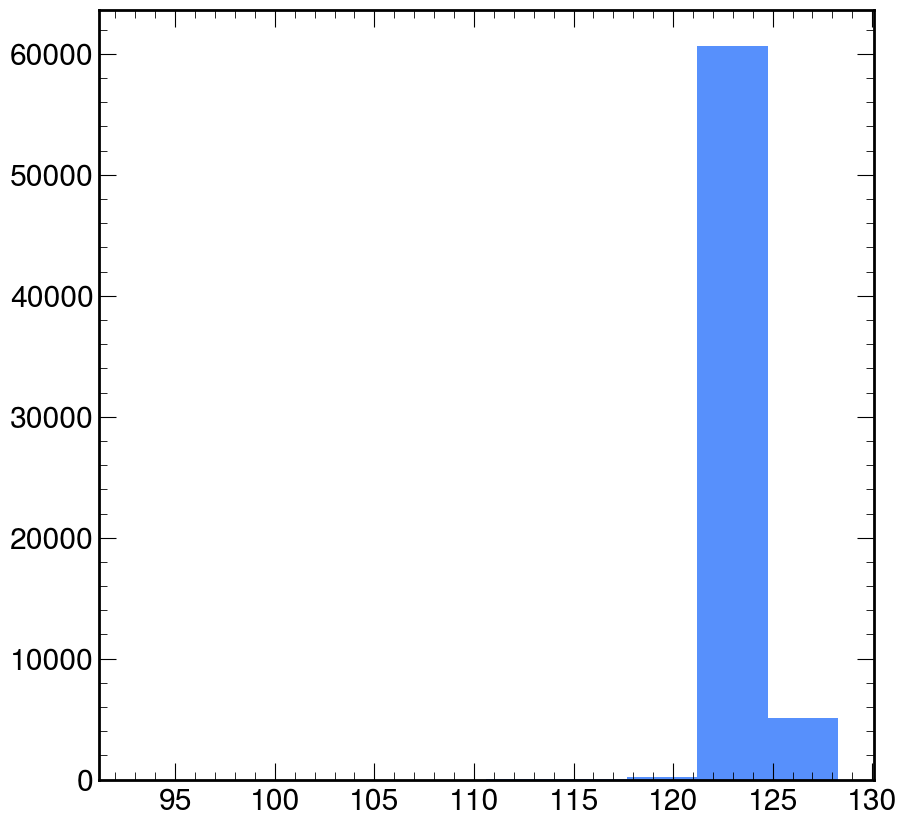

In [191]:
plt.hist((genparts_flat[b_from_higgs_idx_G[:,0]]+genparts_flat[b_from_higgs_idx_G[:,1]]).mass)

(array([30049.,   364.,   511.,   965.,  1740.,  2819.,  4156.,  5924.,
         9023., 10379.]),
 array([  0.        ,  12.48744869,  24.97489738,  37.46234512,
         49.94979477,  62.43724442,  74.92469025,  87.41213989,
         99.89958954, 112.38703918, 124.87448883]),
 <BarContainer object of 10 artists>)

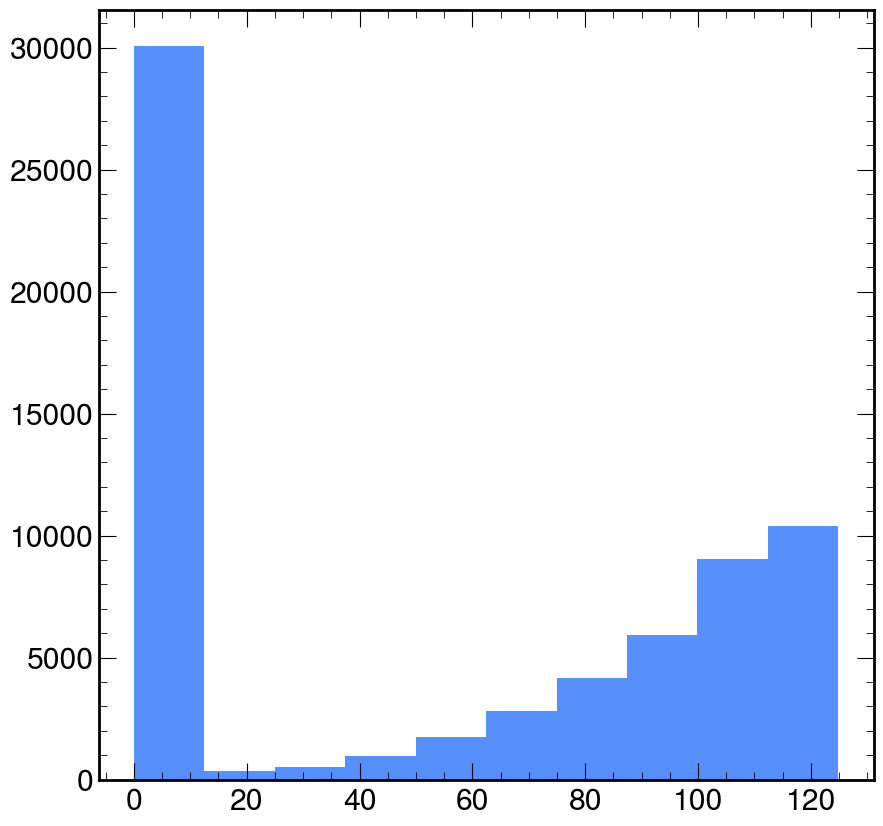

In [203]:
plt.hist((genparts_flat[out_H[:,0]]+genparts_flat[out_H[:,1]]).mass)

## Follow decay of the ISR

In [274]:
out_isr = analyze_parton_decays_flat(ak.to_numpy(isr_idxG, allow_missing=True)[:,None], 
                          ak.flatten(children_idxG, axis=1), 
                         ak.without_parameters(ak.flatten(genparts.pt, axis=1),behavior={}))

# Putting all together

In [12]:
children_idxG = ak.without_parameters(genparts.childrenIdxG, behavior={})
children_idxG_flat = ak.flatten(children_idxG, axis=1)
genparts_flat = ak.flatten(genparts)
genparts_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genparts, axis=1), allow_missing=True))])
local_index_all = ak.local_index(genparts, axis=1)

# Get the initial partons, first copy
initial = genparts.genPartIdxMother == 0
hard_process = (genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess', 'isFirstCopy'])) & (genparts.status !=21) # exclude incoming particles
genparts_hard = genparts[hard_process]

# I want to take hardProcess, final state, BEFORE FSR particles, which have higgs, top, antitop as parents
from_higgs = genparts_hard.parent.pdgId == 25
from_top = genparts_hard.parent.pdgId == 6
from_antitop = genparts_hard.parent.pdgId == -6

higgs = genparts_hard[genparts_hard.pdgId == 25]
top = genparts_hard[genparts_hard.pdgId == 6]
antitop = genparts_hard[genparts_hard.pdgId == -6]

genparts_initial = genparts[initial]

isr = genparts_initial[(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                          (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)]
has_isr = ak.num(isr)!=0
isr_idx = ak.flatten(ak.fill_none(ak.pad_none(local_index_all[initial][(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                          (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)], 1), 0))

######

part_from_top = genparts_hard[from_top]
W_from_top = ak.flatten(part_from_top[part_from_top.pdgId ==24])
b_from_top = ak.flatten(part_from_top[part_from_top.pdgId ==5])
part_from_antitop = genparts_hard[from_antitop]
W_from_antitop = ak.flatten(part_from_antitop[part_from_antitop.pdgId == -24])
b_from_antitop = ak.flatten(part_from_antitop[part_from_antitop.pdgId == -5])

b_from_top_idx = ak.flatten(local_index_all[hard_process][from_top][part_from_top.pdgId ==5])
W_from_top_idx = ak.flatten(local_index_all[hard_process][from_top][part_from_top.pdgId == 24])
b_from_antitop_idx = ak.flatten(local_index_all[hard_process][from_antitop][part_from_antitop.pdgId == -5])
W_from_antitop_idx = ak.flatten(local_index_all[hard_process][from_antitop][part_from_antitop.pdgId == -24])

# This works because they are the firstCopy of the hard_process particles with higgs as parent. We are skipping all the decay chain of the higgs
b_from_higgs_idx = local_index_all[hard_process][from_higgs]
b_from_higgs = genparts_hard[from_higgs]

#--------------
b_from_top_idxG = ak.to_numpy(b_from_top_idx + genparts_offsets[:-1], allow_missing=False)
W_from_top_idxG = ak.to_numpy(W_from_top_idx + genparts_offsets[:-1], allow_missing=False)
b_from_antitop_idxG = ak.to_numpy(b_from_antitop_idx + genparts_offsets[:-1], allow_missing=False)
W_from_antitop_idxG = ak.to_numpy(W_from_antitop_idx + genparts_offsets[:-1], allow_missing=False)
isr_idxG = ak.to_numpy(isr_idx + genparts_offsets[:-1], allow_missing=False)
b_from_higgs_idxG = ak.to_numpy(b_from_higgs_idx + genparts_offsets[:-1], allow_missing=False)

In [13]:
W_from_top_islep, W_from_top_decay = analyze_W_flat( W_from_top_idxG, 
                                                      children_idxG_flat,
                                                      ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}))

W_from_antitop_islep, W_from_antitop_decay = analyze_W_flat( W_from_antitop_idxG, 
                                                              children_idxG_flat,
                                                              ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}))

#part_from_Wtop = genparts_flat[W_from_top_decay]
#part_from_Wantitop = genparts_flat[W_from_antitop_decay]

In [42]:
ak.local_index(events, axis=0)[(W_from_top_islep ^ W_from_antitop_islep)!= semilep]

<Array [] type='0 * int64'>

In [14]:
part_input_G  = np.concatenate([b_from_top_idxG[:,None],
                          b_from_antitop_idxG[:,None],
                          b_from_higgs_idxG,
                          isr_idxG[:,None],
                          W_from_top_decay,
                          W_from_antitop_decay,
                         ], axis=1)

parton_decay_id = analyze_parton_decays_flat_nomesons(part_input_G,
                          children_idxG_flat,
                         ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}), max_deltaR=1)

In [15]:
parton_decay_id

array([[     44,      42,      30, ...,      27,       0,       0],
       [    125,     108,     121, ...,     111,       0,       0],
       [    186,     181,     193, ...,       0,     183,     184],
       ...,
       [7704237, 7704228, 7704232, ...,       0, 7704229, 7704230],
       [7704313, 7704311, 7704309, ..., 7704307,       0,       0],
       [7704372, 7704369, 7704376, ..., 7704374,       0,       0]])

In [14]:
part_from_Wtop_lastcopy

<GenParticleArray [[GenParticle, ... GenParticle]] type='100000 * 2 * genParticle'>

In [14]:
parton_decay_id

array([[     44,      42,      30, ...,      27,       0,       0],
       [    125,     108,     121, ...,     111,       0,       0],
       [    186,     181,     193, ...,       0,     183,     184],
       ...,
       [7704237, 7704228, 7704232, ...,       0, 7704229, 7704230],
       [7704313, 7704311, 7704309, ..., 7704307,       0,       0],
       [7704372, 7704369, 7704376, ..., 7704374,       0,       0]])

In [ ]:
indices = np.stack()

In [23]:
parton_decay_id[:,5:7] = np.where(W_from_top_islep[:,None], W_from_top_decay, parton_decay_id[:,5:7])
parton_decay_id[:,7:9] = np.where(W_from_antitop_islep[:,None], W_from_antitop_decay, parton_decay_id[:,7:9])

In [36]:
parts_lastcopy = genparts_flat[parton_decay_id]
parts_firstcopy = genparts_flat[part_input_G]

In [22]:
b_from_top_lastcopy = genparts_flat[parton_decay_id[:,0]]
b_from_antitop_lastcopy = genparts_flat[parton_decay_id[:,1]]
b_from_higgs_lastcopy = genparts_flat[parton_decay_id[:,2:4]]
isr_lastcopy = genparts_flat[parton_decay_id[:,4]]
part_from_Wtop_lastcopy = genparts_flat[np.where(W_from_top_islep[:,None], W_from_top_decay, parton_decay_id[:,5:7])]
part_from_Wantitop_lastcopy = genparts_flat[np.where(W_from_antitop_islep[:,None], W_from_antitop_decay, parton_decay_id[:,7:9])]

### Validations

In [28]:
W_from_top_islep.shape

(100000,)

Text(1, 0, 'W mass')

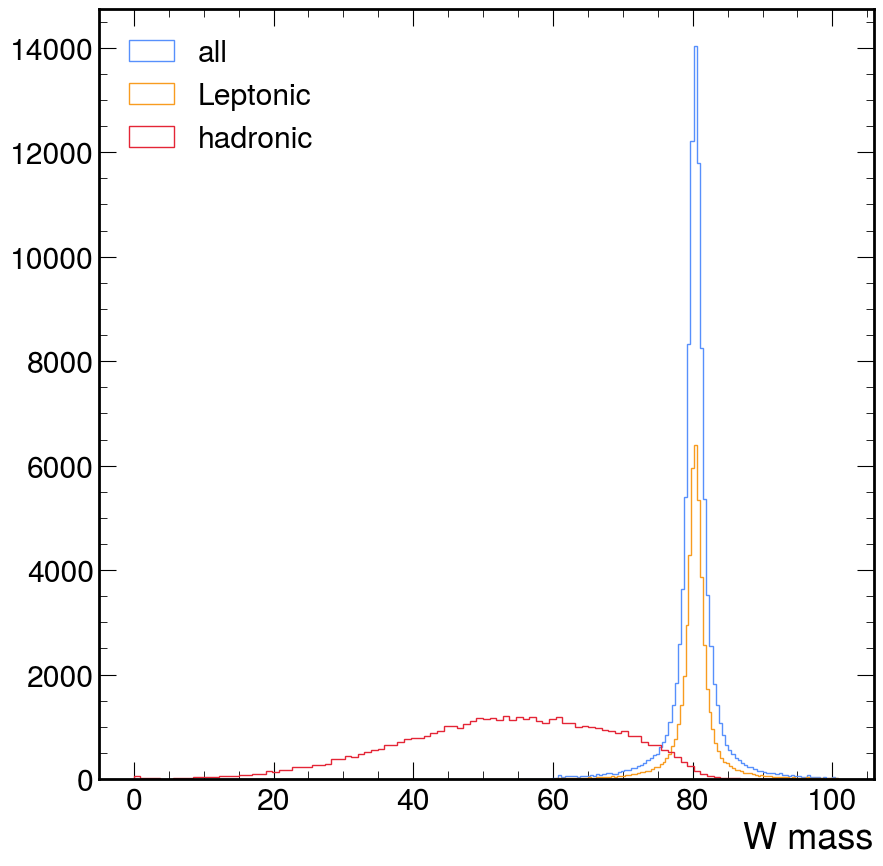

In [31]:
plt.hist((part_from_Wtop[:,0]+part_from_Wtop[:,1]).mass, bins=100, histtype="step", label="all");
plt.hist((part_from_Wtop_lastcopy[W_from_top_islep,0]+part_from_Wtop_lastcopy[W_from_top_islep,1]).mass, bins=100, histtype="step", label="Leptonic");
plt.hist((part_from_Wtop_lastcopy[~W_from_top_islep,0]+part_from_Wtop_lastcopy[~W_from_top_islep,1]).mass, bins=100, histtype="step", label="hadronic");
plt.legend()
plt.xlabel("W mass")

Text(1, 0, 'top mass')

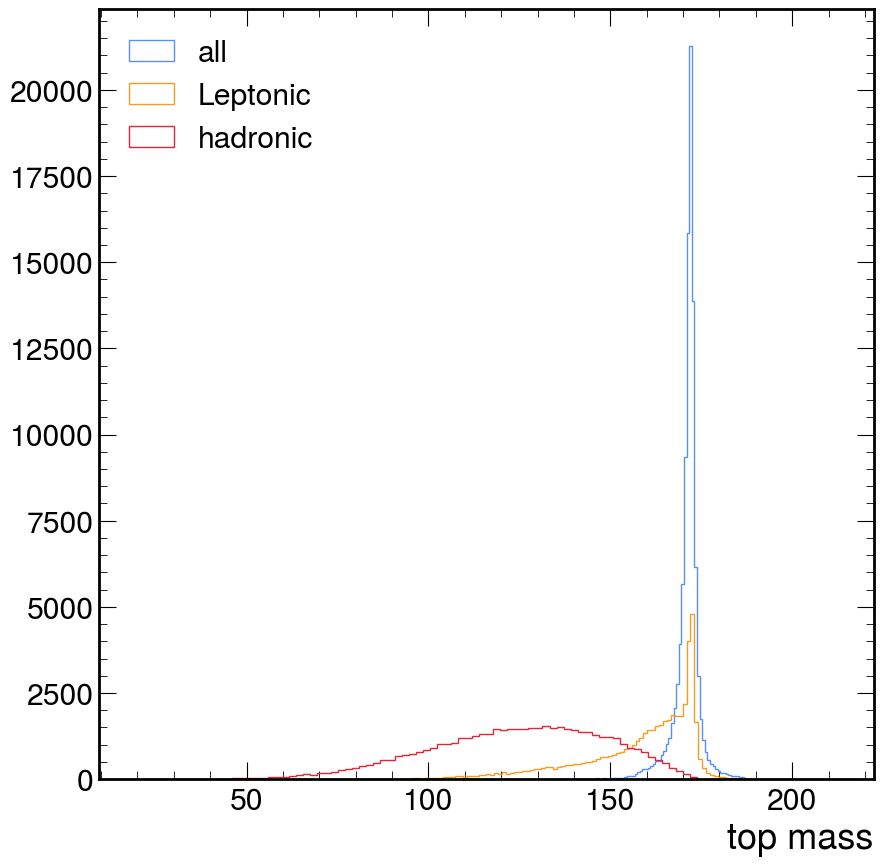

In [34]:
plt.hist((part_from_Wtop[:,0]+part_from_Wtop[:,1] + b_from_top).mass, bins=100, histtype="step", label="all");
plt.hist((part_from_Wtop_lastcopy[W_from_top_islep,0]+part_from_Wtop_lastcopy[W_from_top_islep,1]+ b_from_top_lastcopy[W_from_top_islep]).mass, bins=100, histtype="step", label="Leptonic");
plt.hist((part_from_Wtop_lastcopy[~W_from_top_islep,0]+part_from_Wtop_lastcopy[~W_from_top_islep,1]+ b_from_top_lastcopy[~W_from_top_islep]).mass, bins=100, histtype="step", label="hadronic");
plt.legend()
plt.xlabel("top mass")

/t3home/dvalsecc/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


Text(1, 0, 'Higgs mass')

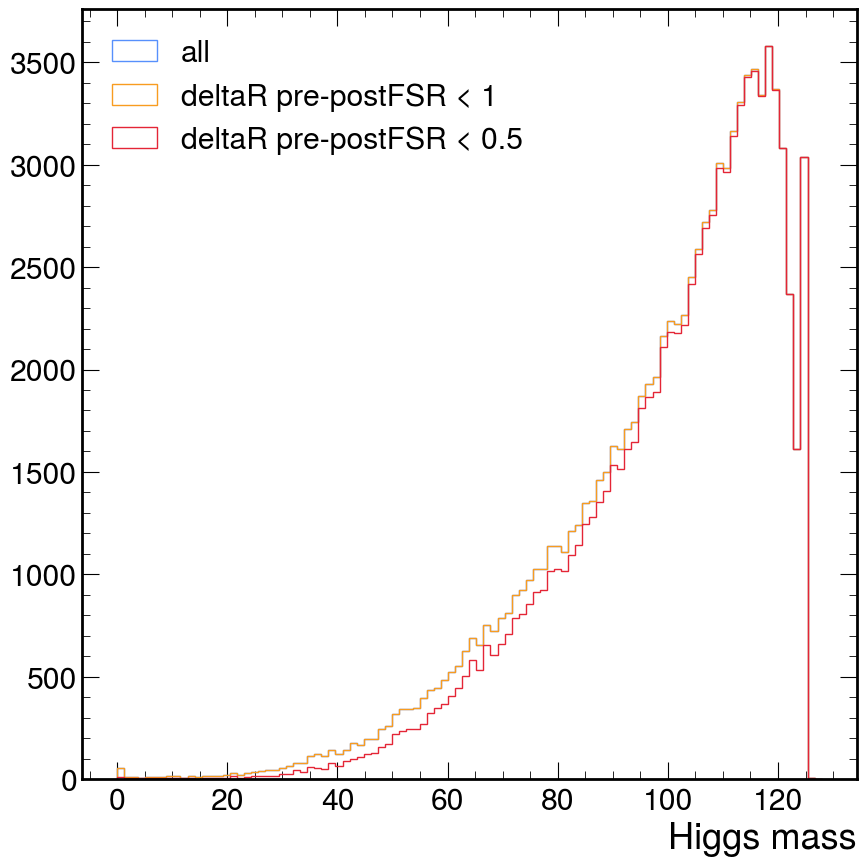

In [129]:
deltaR_higgs1 = b_from_higgs1_lastcopy.delta_r(b_from_higgs[:,0]) 
deltaR_higgs2 = b_from_higgs2_lastcopy.delta_r(b_from_higgs[:,1]) 

plt.hist((b_from_higgs1_lastcopy+ b_from_higgs2_lastcopy).mass, bins=100, histtype="step", label="all");
plt.hist((b_from_higgs1_lastcopy+ b_from_higgs2_lastcopy).mass[(deltaR_higgs1<1)&(deltaR_higgs2<1)], bins=100, histtype="step", label="deltaR pre-postFSR < 1");
plt.hist((b_from_higgs1_lastcopy+ b_from_higgs2_lastcopy).mass[(deltaR_higgs1<0.6)&(deltaR_higgs2<0.6)], bins=100, histtype="step", label="deltaR pre-postFSR < 0.5");

plt.legend()
plt.xlabel("Higgs mass")

Text(1, 0, 'deltaR (pre, post FSR)')

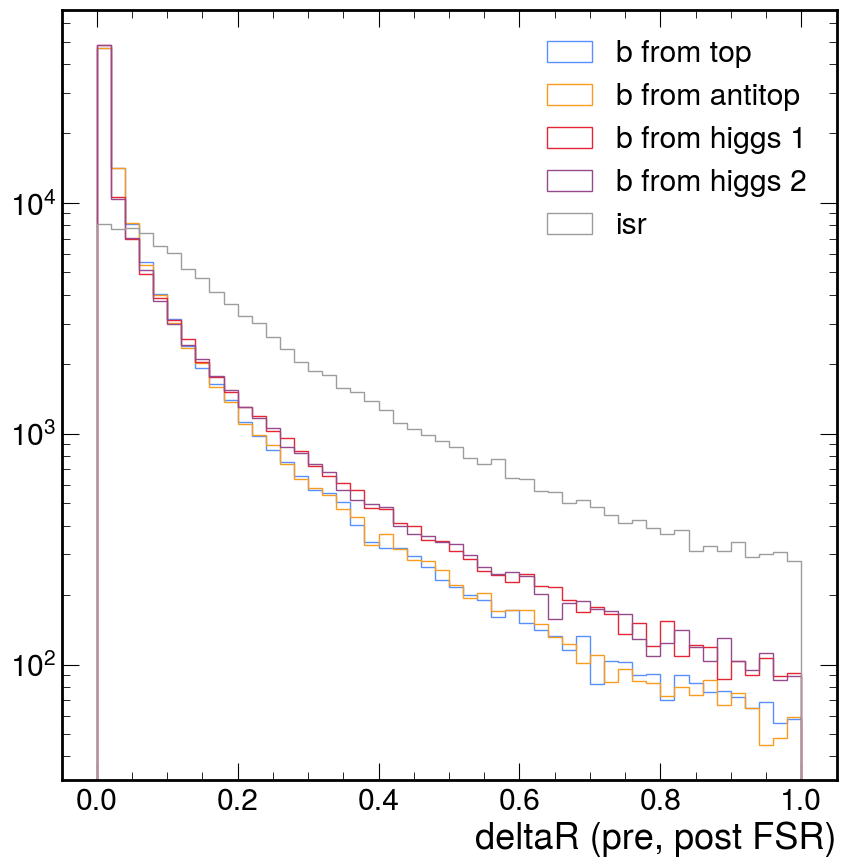

In [130]:
plt.hist(b_from_top_lastcopy.delta_r(b_from_top), range=(0,1), bins=50, label="b from top", histtype="step")
plt.hist(b_from_antitop_lastcopy.delta_r(b_from_antitop), range=(0,1), bins=50, label="b from antitop", histtype="step")

plt.hist(b_from_higgs1_lastcopy.delta_r(b_from_higgs[:,0]), range=(0,1), bins=50, label="b from higgs 1", histtype="step")
plt.hist(b_from_higgs2_lastcopy.delta_r(b_from_higgs[:,1]), range=(0,1), bins=50, label="b from higgs 2", histtype="step")

plt.hist(isr_lastcopy[has_isr].delta_r(isr[has_isr]), range=(0,1), bins=50, label="isr", histtype="step")
plt.yscale("log")
plt.legend()
plt.xlabel("deltaR (pre, post FSR)")

In [131]:
ak.local_index(events, axis=0)[b_from_higgs1_lastcopy.delta_r(b_from_higgs[:,0]) > 0.4]

<Array [37, 40, 54, ... 99977, 99985, 99990] type='6157 * ?int64'>

In [132]:
print_tree_event(54, 0)

pdgId:1, status:21, GenPart (54, 0), mother -1, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:0.000, eta:24128.000, phi:0.000
+ pdgId:25, status:22, GenPart (54, 2), mother 0, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:33.250, eta:0.190, phi:-3.117         --> initial copy, hard process 
| | pdgId:25, status:44, GenPart (54, 6), mother 2, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:32.875, eta:0.210, phi:-3.078
| | | pdgId:25, status:44, GenPart (54, 7), mother 6, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:30.750, eta:0.203, phi:-3.125
| | | | pdgId:25, status:44, GenPart (54, 8), mother 7, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:0         pt:30.375, eta:0.214, phi:-3.133
| | | | | pdgId:25, status:44, GenPart (54, 9), mother 8, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirst

## Matching with GenJets

In [39]:
from pocket_coffea.lib.deltaR_matching import object_matching,get_matching_pairs_indices,get_matching_objects_indices_padnone

In [40]:
# Calling our general object_matching function.
# The output is an awkward array with the shape of the second argument and None where there is no matching.
# So, calling like this, we will get out an array of matched_quarks with the dimension of the JetGood.
matched_quarks, matched_jets, deltaR_matched = object_matching(
    parts_firstcopy, events.Jet, dr_min=0.4
)

matched_quarks, matched_jets, deltaR_matched_hard = object_matching(
    parts_lastcopy, events.Jet, dr_min=0.4
)


Text(1, 0, 'first copy')

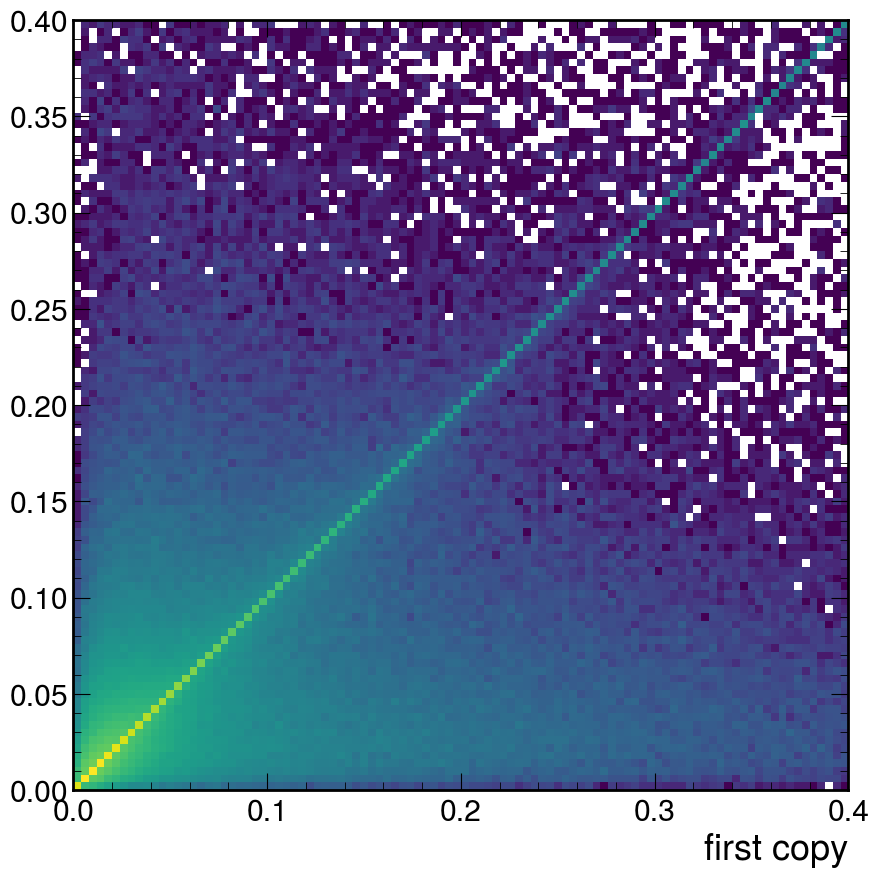

In [41]:
plt.hist2d(ak.to_numpy(ak.fill_none(ak.flatten(deltaR_matched), 10)),
           ak.to_numpy(ak.fill_none(ak.flatten(deltaR_matched_hard), 10)), bins=100, range=((-1e-6, 0.4),(-1e-6, 0.4)), norm=LogNorm() )
plt.xlabel("last copy")
plt.xlabel("first copy")

In [49]:
print("Increase of matching efficiency%:" , ak.sum((ak.fill_none(ak.flatten(deltaR_matched), 10) < 10) & (ak.fill_none(ak.flatten(deltaR_matched_hard), 10) == 10) )*100 /ak.sum(ak.num(deltaR_matched, axis=1)))

Increase of matching efficiency%: 13.399424301064853


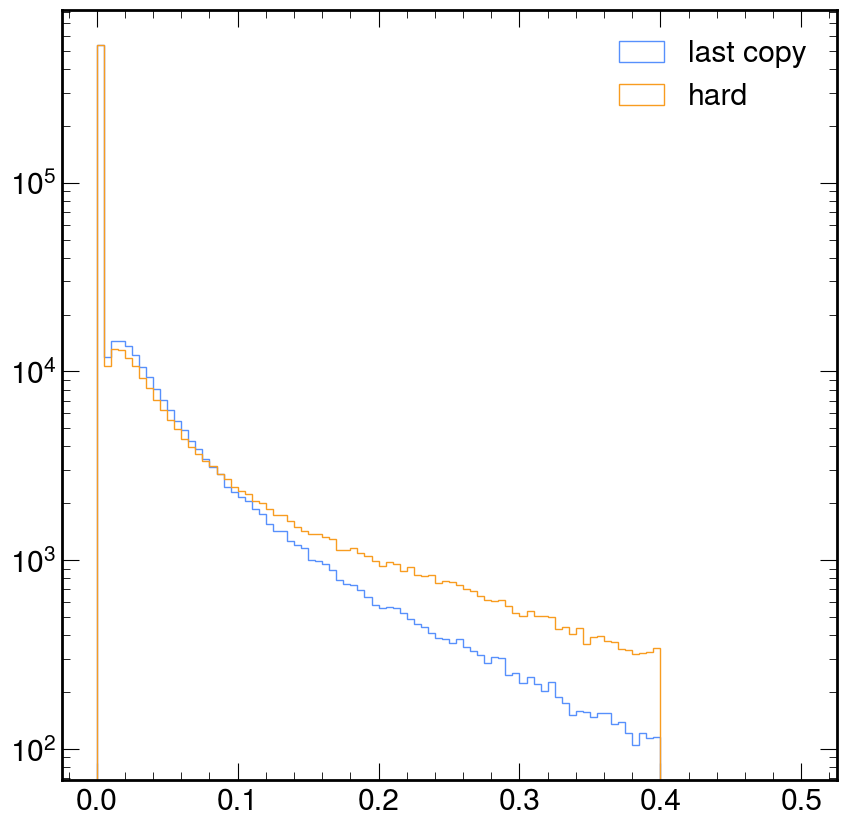

In [140]:
plt.hist(ak.flatten(deltaR_matched), bins=100, range=(-1e-6, 0.5), label="last copy", histtype="step");
plt.hist(ak.flatten(deltaR_matched_hard), bins=100, range=(-1e-6, 0.5), label="hard", histtype="step");
plt.legend()
plt.yscale("log")

# Analyzing childrens using coffea nanoevents

In [27]:
genparts[hard_process][from_higgs][0:10,1].children.pdgId.tolist()

[[-513, -5, 523],
 [],
 [-5, 421, 511, 21, -523, -421],
 [21, -5],
 [],
 [-5, 511],
 [-5, 521],
 [21, -5],
 [21, -5],
 [-523, -411, -5, 413, 523]]

In [159]:
genparts[0, 14].fields

['eta',
 'mass',
 'phi',
 'pt',
 'genPartIdxMother',
 'pdgId',
 'status',
 'statusFlags',
 'genPartIdxMotherG',
 'distinctParentIdxG',
 'childrenIdxG',
 'distinctChildrenIdxG',
 'distinctChildrenDeepIdxG']

In [34]:
print_tree_event(2, 26)

pdgId:-5, status:23, GenPart (2, 26), fromHardProcess:1, isHardProcess:1, isLastCopy:0         pt:86.000, eta:2.344, phi:-1.402
| pdgId:-5, status:71, GenPart (2, 27), fromHardProcess:1, isHardProcess:0, isLastCopy:1         pt:14.031, eta:1.559, phi:1.141
| pdgId:421, status:2, GenPart (2, 28), fromHardProcess:0, isHardProcess:0, isLastCopy:1         pt:6.125, eta:2.641, phi:-1.293
| pdgId:511, status:2, GenPart (2, 29), fromHardProcess:0, isHardProcess:0, isLastCopy:1         pt:14.094, eta:1.582, phi:1.117
| | pdgId:-413, status:2, GenPart (2, 54), fromHardProcess:0, isHardProcess:0, isLastCopy:1         pt:5.141, eta:1.508, phi:1.113
| | | pdgId:-411, status:2, GenPart (2, 69), fromHardProcess:0, isHardProcess:0, isLastCopy:1         pt:4.859, eta:1.500, phi:1.117
| pdgId:21, status:71, GenPart (2, 35), fromHardProcess:0, isHardProcess:0, isLastCopy:1         pt:30.125, eta:2.617, phi:-1.367
| pdgId:-523, status:2, GenPart (2, 36), fromHardProcess:0, isHardProcess:0, isLastCopy:1  

In [35]:
b_from_H_0 = genparts[hard_process][from_higgs][:,0]

In [42]:
b_from_H_0.children

<GenParticleArray [[GenParticle], ... GenParticle]] type='1000 * var * ?genParticle'>

In [20]:
genparts[genparts.status == 1].pdgId[0:10].tolist()

[[-16,
  16,
  -211,
  14,
  -13,
  11,
  -11,
  22,
  22,
  22,
  22,
  16,
  -13,
  14,
  -16,
  211,
  22,
  22,
  22,
  22],
 [11, -12, 11, -11, 11, -11],
 [22, 16, -16, 211, 22, 22],
 [13, -14, 14, -13, -14, 13, 14, -13],
 [22, -13, 22, 14, 22, 11, -11, 11, -11, 11, -11, 11, -11, 22, 22],
 [11, -12, 22, -13, 14],
 [-16, 16, 11, -12, 14, -13, -14, 13, 13, -14],
 [22, -16, 16, 13, -14, -14, 13, 22, 22, 13, -14],
 [13, -14, 16, -14, 13, -16, -13, 14, 22],
 [13, -14, 11, -11, 12, -11, 11, -12, 22, 22, 22]]

In [21]:
genparts[0, 14].children.hasFlags(["isLastCopy"]).tolist()

[True, True]

In [25]:
genparts[hard_process][from_W][0:10].pdgId.tolist()

[[-13, 14],
 [-3, 4],
 [-15, 16],
 [-3, 4],
 [-3, 4],
 [-15, 16],
 [-1, 2],
 [-3, 4],
 [-3, 4],
 [-1, 2]]

In [30]:
genparts[hard_process][from_W][0:10].pdgId.tolist()

[[-13, 14],
 [-3, 4],
 [-15, 16],
 [-3, 4],
 [-3, 4],
 [-15, 16],
 [-1, 2],
 [-3, 4],
 [-3, 4],
 [-1, 2]]

In [29]:
genparts[hard_process][from_W][0:10].hasFlags(["isLastCopy"]).tolist()

[[True, True],
 [False, False],
 [True, True],
 [False, False],
 [False, False],
 [True, True],
 [False, False],
 [False, False],
 [False, False],
 [False, False]]

In [46]:
genparts[0, 2].tolist()

{'eta': -2.8203125,
 'mass': 125.0,
 'phi': 1.01953125,
 'pt': 68.5,
 'genPartIdxMother': 0,
 'pdgId': 25,
 'status': 22,
 'statusFlags': 4481,
 'genPartIdxMotherG': 0,
 'distinctParentIdxG': 0,
 'childrenIdxG': [6],
 'distinctChildrenIdxG': [],
 'distinctChildrenDeepIdxG': [26, 27]}

In [121]:
genparts[0, 18].distinctChildrenDeep.tolist()

[{'eta': -0.068603515625,
  'mass': 0.0,
  'phi': -1.203125,
  'pt': 26.3125,
  'genPartIdxMother': 21,
  'pdgId': 3,
  'status': 23,
  'statusFlags': 4481,
  'genPartIdxMotherG': 21,
  'distinctParentIdxG': 21,
  'childrenIdxG': [30],
  'distinctChildrenIdxG': [],
  'distinctChildrenDeepIdxG': [30]},
 {'eta': -2.3984375,
  'mass': 0.0,
  'phi': -2.8671875,
  'pt': 21.875,
  'genPartIdxMother': 21,
  'pdgId': -4,
  'status': 23,
  'statusFlags': 22913,
  'genPartIdxMotherG': 21,
  'distinctParentIdxG': 21,
  'childrenIdxG': [35, 36],
  'distinctChildrenIdxG': [36],
  'distinctChildrenDeepIdxG': [36, 35]}]

In [15]:
genparts[hard_process].pdgId[0:10].to_list()

[[21, 21, 25, 6, -6, 21, 5, 24, -5, -24, -13, 14, 3, -4, 5, -5],
 [-2, 2, 25, 6, -6, 21, 5, 24, -5, -24, -3, 4, 3, -2, 5, -5],
 [21, 21, 25, 6, -6, 21, 5, 24, -5, -24, -15, 16, 3, -4, 5, -5],
 [21, 21, 25, 6, -6, 21, 5, 24, -5, -24, -3, 4, 11, -12, 5, -5],
 [21, 2, 25, 6, -6, 2, 5, 24, -5, -24, -3, 4, 3, -4, 5, -5],
 [2, 21, 25, 6, -6, 2, 5, 24, -5, -24, -15, 16, 15, -16, 5, -5],
 [21, 21, 25, 6, -6, 21, 5, 24, -5, -24, -1, 2, 13, -14, 5, -5],
 [21, 21, 25, 6, -6, 21, 5, 24, -5, -24, -3, 4, 1, -2, 5, -5],
 [21, 21, 25, 6, -6, 21, 5, 24, -5, -24, -3, 4, 1, -2, 5, -5],
 [-2, 2, 25, 6, -6, 21, 5, 24, -5, -24, -1, 2, 1, -2, 5, -5]]

In [25]:
genparts[0, 5].parent.tolist()

{'eta': 23104.0,
 'mass': 0.0,
 'phi': 0.0,
 'pt': 0.0,
 'genPartIdxMother': -1,
 'pdgId': 21,
 'status': 21,
 'statusFlags': 2433,
 'genPartIdxMotherG': -1,
 'distinctParentIdxG': -1,
 'childrenIdxG': [2, 3, 4, 5],
 'distinctChildrenIdxG': [2, 3, 4, 6, 7, 8, 9, 11, 12, 13],
 'distinctChildrenDeepIdxG': []}

In [47]:
genparts[hard_process][initial]

<GenParticleArray [[None, None, ... GenParticle]] type='1000 * var * ?genParticle'>

In [58]:
local_index[hard_process][0:5].tolist()

[[0, 1, 2, 3, 4, 5, 14, 15, 17, 18, 22, 23, 24, 25, 26, 27],
 [0, 1, 2, 3, 4, 5, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 [0, 1, 2, 3, 4, 5, 14, 15, 17, 18, 19, 20, 21, 22, 25, 26],
 [0, 1, 2, 3, 4, 5, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25],
 [0, 1, 2, 3, 4, 5, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22]]

In [55]:
genparts[hard_process][initial][is_higgs].pdgId[0:10].tolist()

[[25], [25], [25], [25], [25], [25], [25], [25], [25], [25]]

In [61]:
local_index[hard_process][initial][is_top]

<Array [[3], [3], [3], ... [3], [3], [3]] type='1000 * var * int64'>

In [71]:
top = ak.flatten(genparts[hard_process][initial][is_top], axis=1)
top

<GenParticleArray [GenParticle, ... GenParticle] type='1000 * genParticle'>

In [83]:
top.children.children.children.children.children.pdgId[0:10].tolist()

[[[[[], [[413, -433]]], [[[], []]]]],
 [[[[[-521]]], [[[], []], [[]]]]],
 [[[[]], [[[-16, -13, 14], []]]]],
 [[[[], [[-431, 411]], []], [[[421, 21, -3], [4]]]]],
 [[[[[423, 111]]], [[[]], [[], [], []]]]],
 [[[[[-511], [], []]], [[[], [22, 22], [22, 22], []], []]]],
 [[[[], [[]]], [[[-1, 2], []]]]],
 [[[[[-511]], []], [[[-3], [4, 421]]]]],
 [[[[], [[-431], [421]]], [[[21, -3], [4, 431, 221, 111]]]]],
 [[[[], [[-16, 15, 423]]], [[[-1], [2]]]]]]

In [75]:
genparts[0, 14].tolist()

{'eta': -2.2109375,
 'mass': 0.0,
 'phi': -2.625,
 'pt': 56.75,
 'genPartIdxMother': 12,
 'pdgId': 5,
 'status': 23,
 'statusFlags': 22913,
 'genPartIdxMotherG': 12,
 'distinctParentIdxG': 12,
 'childrenIdxG': [37, 38],
 'distinctChildrenIdxG': [38],
 'distinctChildrenDeepIdxG': [38, 37]}

In [70]:
top[0:10].tolist()

[{'eta': -3.7734375,
  'mass': 170.5,
  'phi': 1.6953125,
  'pt': 22.4375,
  'genPartIdxMother': 0,
  'pdgId': 6,
  'status': 22,
  'statusFlags': 4481,
  'genPartIdxMotherG': 0,
  'distinctParentIdxG': 0,
  'childrenIdxG': [12],
  'distinctChildrenIdxG': [],
  'distinctChildrenDeepIdxG': [14, 15]},
 {'eta': -3.703125,
  'mass': 171.5,
  'phi': -2.9765625,
  'pt': 86.75,
  'genPartIdxMother': 0,
  'pdgId': 6,
  'status': 22,
  'statusFlags': 4481,
  'genPartIdxMotherG': 69,
  'distinctParentIdxG': 69,
  'childrenIdxG': [80],
  'distinctChildrenIdxG': [],
  'distinctChildrenDeepIdxG': [82, 83]},
 {'eta': 2.140625,
  'mass': 172.0,
  'phi': 2.6171875,
  'pt': 136.5,
  'genPartIdxMother': 0,
  'pdgId': 6,
  'status': 22,
  'statusFlags': 4481,
  'genPartIdxMotherG': 128,
  'distinctParentIdxG': 128,
  'childrenIdxG': [140],
  'distinctChildrenIdxG': [],
  'distinctChildrenDeepIdxG': [142, 143]},
 {'eta': 1.65234375,
  'mass': 172.5,
  'phi': 1.22265625,
  'pt': 174.5,
  'genPartIdxMother'

(array([2.9701e+04, 2.2614e+04, 8.1830e+03, 7.1710e+03, 6.5970e+03,
        3.3740e+03, 1.2220e+03, 2.4800e+02, 8.6000e+01, 1.2000e+01]),
 array([ -1. ,  12.9,  26.8,  40.7,  54.6,  68.5,  82.4,  96.3, 110.2,
        124.1, 138. ]),
 <BarContainer object of 10 artists>)

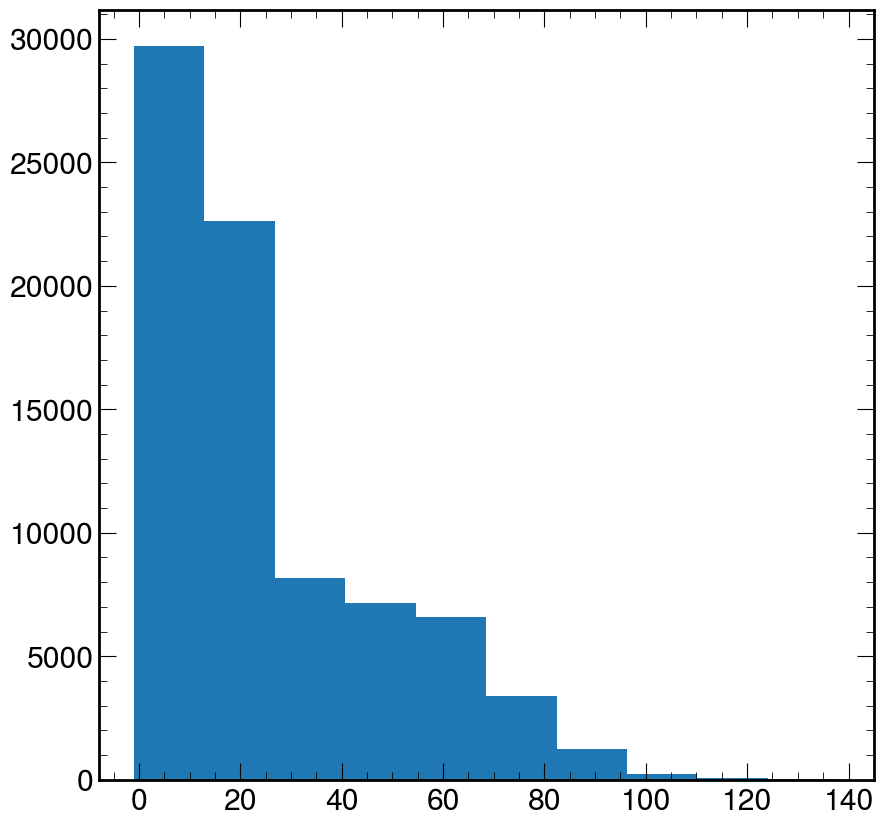

In [169]:
plt.hist(genparts_flat.genPartIdxMother)